<img src="skoltech_logo.png" alt="Skoltech" width=80% height=60% style="padding-right:80px;"/>
<h1 style="color:#333333; text-align:center; line-height: 0;">Reinforcement Learning</h1>
<h5 style="color:#333333; text-align:center;">Course MA030422</h5>

<h2 style="color:#A7BD3F;">Homework 2</h2>

***

### Intro

#### First, a recap of homework 1

In homework 1 we applied value iteration and policy iteration to an environment with discrete state and action spaces (aka a finite MDP). If you recall, the environment we used (FrozenLake 4x4) had 16 states and 4 actions. 

#### The algorithms from hw 1 have several characteristics:
* The tabular representations of MDP variables had to be stored in memory:
    * In the case of VI, the values of states, transitions, and rewards were stored in memory and referenced when calculating the best action to take
    * In the case of PI, policy was additionally stored in memory.
* Neither value nor policy functions were represented mathematically/analytically
* Both value iteration (VI) and policy iteration (PI) were *repeatedly and reliably* able to solve the environment (when `is_slippery==False`)

#### The problem with *Exact Value Iteration* and *Exact Policy Iteration*

The problem with VI and PI from homework 1 is that when MDP variables (states, actions, transitions, or rewards) "have a very large or infinite number of possible values (e.g., when they are continuous)", then Tabular/stored "representations are no longer possible, and value functions and policies need to be represented approximately" <sup>[2]</sup>.

Let's examine this issue in more specific terms. Examine the following VI algorithm <sup>[1]</sup>:

<img src="vi.png" width="70%" height="70%" />

This algorithm is nearly identical to VI from hw 1. What problems/deficiencies can you identify in this algorithm if we had to scale it by 30 orders of magnitude? 

At least 5 problems/deficiencies come to mind with regard to scale <sup>[1]</sup>:
1. All of the states are iterated over (line 3)
2. Value of state $V(s)$ is stored for every state (line 5)
3. Policy $\pi$ is stored for every state (line 6)
4. The expected return over future states ($s^\prime$) is calculated recursively for all $s^\prime$ (lines 5 and 6)
5. Maximization is performed over all possible actions (lines 5 and 6)

When designing VI and PI algorithms for **continuous** state and/or action spaces, all of these problems can be addressed with **approximation**, which, when applied to the DP methods (such as VI and PI) is known as **Approximate Dynamic Programming**.

### Goal of this homework

The purpose of this assignment is to learn about and practice applying approximation methods to continuous space environments, specifically ENDI from Rcognita.

### Components

* **Section 1**: Concept Review
* **Section 2**: Approximate Dynamic Programming
    * Exercise 1 - Linear Function Approximation
        * Problem 1.1 - 15 points

Total points: 15

<h2 style="color:#A7BD3F;">Imports and Autograder</h2>

***
Take care of imports early on:

In [1]:
from rcognita import EndiSystem, EndiControllerBase, Simulation, AnswerTracker
from IPython.display import HTML, clear_output
import numpy as np
import scipy as sp
from scipy.optimize import minimize

In [2]:
sp.__version__

'1.4.1'

### <font color="orange">Auto-grading</font>
Run this cell to track your answers.

In [3]:
### GRADING DO NOT MODIFY
hw2_answers = AnswerTracker()

<h2 style="color:#A7BD3F;">Section 1 - Concept Review</h2>

***

The following concepts will help you in completing this assignment and furthering your understanding of common taxonomy in the field of RL.

### Dynamic Programming vs Reinforcement Learning

Dynamic programming refers to a class of optimization methods that solve problems through recursion and aggregation, or more formally by "by combining solutions from their subproblems" <sup>[1]</sup>.
<blockquote><b>DP algorithms</b> require a model of the MDP, including the transition dynamics
and the reward function, to find an optimal policy (Bertsekas, 2007; Powell, 2007).
Usually, they do not require an analytical expression of the
dynamics. Instead, given a state and an action, the model is only required to generate a next state and the corresponding reward. Constructing such a generative model is often easier than deriving an analytical expression of the dynamics, especially when the dynamics are stochastic.<sup>[2]</sup></blockquote>

In contrast, in reinforcement learning algorithms, the underlying model of the environment is unknown:
<blockquote><b>RL algorithms</b> are model-free (Bertsekas and Tsitsiklis, 1996; Sutton and Barto, 1998), which makes them useful when a model is difficult or costly to construct. RL algorithms use data obtained from the process, in the form of a set of samples, a set of process trajectories, or a single trajectory. So, RL can be seen as model-free, sample- based or trajectory-based DP, and DP can be seen as model-based RL. While DP algorithms can use the model to obtain any number of sample transitions from any state-action pair, RL algorithms must work with the limited data that can be obtained from the process – a greater challenge. Note that some RL algorithms build a model from the data; we call these algorithms “model-learning.”<sup>[2]</sup></blockquote>

### Offline vs Online

From [2]:
> * Offline RL methods are applicable if data can be obtained in advance. 
> * Online RL algorithms learn a solution by interacting with the system, and can therefore be applied even when data is not available in advance. For instance, intelligent agents are often placed in environments that are not fully known beforehand, which makes it impossible to obtain data in advance.

### Deterministic vs Stochastic


* **Deterministic**
    * > A deterministic MDP is defined by the state space $X$ of the process, the action space $U$ of the controller, the transition function $f$ of the process (which describes how the state changes as a result of control actions), and the reward function $\rho$ (which evaluates the immediate control performance). <sup>[2]</sup>
* **Stochastic**
    * > In a stochastic MDP, the next state is not deterministically given by the current state and action. Instead, the next state is a random variable, and the current state and action give the probability density of this random variable. <sup>[2]</sup>

<h2 style="color:#A7BD3F;">Section 2 - Approximate Dynamic Programming</h2>

***

From our previous lectures, let us recall the Q-function:

$$Q^{\pi}(s, a)=E_{\pi}\left[\sum_{t=0}^{\infty} \gamma^{t} r_{t} \mid s_{0}=s, a_{0}=a\right]$$

... And in expanded form (for finite state and action spaces):

$$Q^\pi{(s,a)} = \sum_{s^\prime\in\text{S}} P{(s^\prime|s,a)} \left[R(s,a,s^\prime) + \gamma \sum_{a^\prime\in\text{A}} \pi{(a^\prime|s^\prime)} Q^\pi{(s^\prime,a^\prime)}\right]$$


... Which can also be represented in terms of state-value:

$$Q^{\pi}(s, a)=\sum_{s^{\prime} \in \mathcal{S}} P\left(s^{\prime} \mid s, a\right) \left[R\left(s, a, s^{\prime}\right)+\gamma V^{\pi}\left(s^{\prime}\right)\right]$$

This Q-function is a polynomial of $|S|$ (cardinality), which is projected recursively over a trajectory that, even in the case of a substantially large **finite** state-space, would be computationally infeasible to solve from an iteration-time perspective (as well as being too costly from a memory perspective).

The question is, is there an **approximate representation** of $Q(s,a)$ that has a sufficiently small number of parameters (much less than $|S|$)? 

A simple, linear parametric approximation that works well in practice is the following:

$$Q^{\pi}(s, a)=\phi(s, a)^{\top} \boldsymbol{\theta}$$

Where:
* $\phi(s, a) \in \mathbb{R}^{n}$
* $\boldsymbol{\theta} \in \mathbb{R}^{n}$

A word about notation:
* $\phi$ is the feature **function**: $\phi : S \times A \rightarrow \mathbb{R}^{n}$
    * "$\phi$ maps each state-action pair to a vector of feature values" <sup>[1]</sup>
* $\phi(s, a)$ is the feature **vector** of $s$ and $a$
* $\phi_i{(s, a)}$ denotes an feature **value** (aka simply feature) of the feature vector for state $s$ and action $a$
* $\theta$ is the weight vector which denotes the contribution of each feature to Q

Note:
* $\phi$ can also take only $s$ as input

### <font color="blue">Exercise 1 - Linear Function Approximation</font>

To learn and understand value-function **approximation** (specifically Q-function approximation), we will be implementing an algorithm in Rcognita entitled **Trajectory Based Value Iteration Least Squares** (TBVILS) <sup>[1]</sup>:

<img src="tbvils.png" width=70% height=70% />

### How does it work

#### 💡 Line 6

In line 6, the buffers (of size $\beta$) are updated with the current state and action.

#### 💡 Line 7

On line 7 we update the weights of Q-function. This is done by minimizing the cost function known as temporal error (aka delta, $\delta$) with respect to parameters $\theta$:

$$\delta = (Q^{+}(s, a) - Q(s, a))^{2}$$

$$\delta = (r\left(x_{k}, h_{j}\left(x_{k}\right)\right)+W_{j}^{T} \gamma \phi\left(x_{k+1}\right) - W_{j+1}^{T} \phi\left(x_{k}\right))^{2}$$



Where (❗in the case of VI):

* **Approximate Q**: $\hspace{1em} Q(s, a) = W_{j+1}^{T} \phi\left(x_{k}\right)$</font>
* **Target Q**: $\hspace{1em} Q^{+}(s, a) = r\left(x_{k}, h_{j}\left(x_{k}\right)\right)+W_{j}^{T} \gamma \phi\left(x_{k+1}\right)$</font>

Pay close attention to the differences in $W$ and $x$ above.

Thus, for value iteration, for a given time-step, temporal error has the following form <sup>[3]</sup>:

$$e_{k}= \big(r\left(x_{k}, h_{j}\left(x_{k}\right)\right)+W_{j}^{T} \gamma \phi\left(x_{k+1}\right) - W_{j+1}^{T} \phi\left(x_{k}\right)\big)^2$$

The task of optimization is to minimize $e_k$ to 0 by adjusting the weights $W$:

$$0 = \big(r\left(x_{k}, h_{j}\left(x_{k}\right)\right)+W_{j}^{T} \gamma \phi\left(x_{k+1}\right) - W_{j+1}^{T} \phi\left(x_{k}\right)\big)^2$$

**Side-note**:
* In policy iteration, the temporal difference equation looks differently:
$$e_{k}= \big(r\left(x_{k}, h_{j}\left(x_{k}\right)\right)+W_{j}^{T} \gamma \phi\left(x_{k}\right) - W_{j}^{T} \phi\left(x_{k+1}\right)\big)^2$$

#### 💡 Line 8:

This phase is very similar to that of Q-function update, except we are minimizing the $V(s)$ function below with respect to policy weights $\pi_{W}$.

During the policy update phase - the `policy` method in the code performs the following tasks:
1. It takes the current state $s$ and initial action $a$ and generates a trajectory of predicted states over the horizon length.
2. It then calculates the **sum of discounted rewards** over this trajectory:

$$V_{h}\left(x_{k}\right)=\sum_{i=k}^{\infty} \gamma^{i-k} r\left(x_{i}, u_{i}\right) $$
3. Steps 1 and 2 are repeated until cost from step 2 is **minimized** (see next section)

The minimization function that we use is scipy's `minimize`, which is responsible for executing step 3.

### Before you get started: notation details

Rcognita is designed to be used as a framework for DP, RL, *and* control systems. Therefore, we use a variety of notation that is common to these areas.

For example, instead of the following:

$$Q^{\pi}(s, a)=\phi(s, a)^{\top} \boldsymbol{\theta}$$

In our code you will see the Q-function represented as <sup>[3]</sup>:

$$Q_{h}(x, u)=W^{T} \phi(x, u)$$

Where <sup>[3]</sup>:
* $h$ is a **policy** (aka $\pi$)
* $x$ is the **state**
* $y$ is the **output** of a system (which is the same thing as $x$ in our code)
* $u$ is the **control** (aka action)
* $W$ is the weight vector (aka $\theta$)

#### Other related notation and the objective function :

* $\dot{x} = f(x,u)$ - the system dynamics (change in system's state)
* $x_k \in R^n$ - state vector (where $k$ is a time step)
* $u_k = h(x_k)$ - control function (a.k.a. policy function)
    * where $u_k \in R^m$
* $r(x_k, u_k)$ - utility function, aka instantaneous cost or reward function

And finally:

$$V_{h}\left(x_{k}\right)=\sum_{i=k}^{\infty} \gamma^{i-k} r\left(x_{i}, u_{i}\right)$$

While in RL this is known as the *state-value function* with respect to a policy $h$, in dynamical systems and DP, "this is known as the **cost-to-go** and is a sum of discounted future costs from
the current time k into the infinite horizon future" <sup>[3]</sup>. Other names for $V(s)$ include **cost** and **value**.

#### ❗ In the context of control theory, dynamical systems, and this assignment -- <font color="red">the value function is minimized, not maximized</font>.

### <font color="blue">Problem 1</font>

Let's apply the TBVILS algorithm to the ENDI environment from Rcognita. Here is the algorithm again for convenience <sup>[1]</sup>:

<img src="tbvils.png" width=70% height=70% />

### Variables in Rcognita

Recall that in the ENDI environment of Rcognita:
The environment has the following 5 characteristics:
* **x ($x_c$)** = x-coordinate (m)
* **y ($y_c$)** = y-coordinate (m)
* **alpha ($\alpha$)** = turning angle (rad)
* **upsilon ($\upsilon$)** = velocity (m/s)
* **omega ($\omega$)** = revolution speed (rad/s) (aka turning speed)

For a given time-step, $t$:
* Action or control input is given by: $\hspace{3mm}a_t = (F, M)$
* Environment is given by: $\hspace{3mm}s_t = (x_c, y_c, \alpha, \upsilon, \omega)$

Thus in the ENDI environment, $\phi(s,a)$ would be:
* $\phi(s_t, a_t) = (x_c, y_c, \alpha, \upsilon, \omega, F, M)$

Usually $\phi$ takes a quadratic form, in which $\phi : (S \times A)^2 \rightarrow \mathbb{R}^{n}$

**Note**: note that $\phi$ can also take *only* state (in the case of state-value function).

#### 🎯 Task: implement the TBVILS algorithm in the code below by filling in the lines specified by comments
Remember the key functions from above and implement them:

Hints:
* Work method by method, filling in the code where the comments specify.
* When working on the `value_function`, note the:
    * *temporal difference* equation.
    * V(s) (expected return over a trajectory from a given state $s$)

$$e_{k}= \big(r\left(x_{k}, h_{j}\left(x_{k}\right)\right)+W_{j}^{T} \gamma \phi\left(x_{k+1}\right) - W_{j+1}^{T} \phi\left(x_{k}\right)\big)^2$$

In [75]:
# #MINIMIZE


#     # your solution should look very similar to the policy update.
# options = {'maxiter': 200, 'disp': False, 'ftol': 1e-7}

# # вероятно что-то надо в границах менять 
# bounds = sp.optimize.Bounds(agent.w_min, agent.w_max, keep_feasible=True)




# def min_q_function(W):

#             q_s_a = W.T * agent._phi(agent.system_state, agent.u_curr)

#             q_target = agent.running_cost(agent.system_state, agent._policy(agent.system_state, W)) + W *agent.gamma *agent._phi(agent.system_state, agent.u_curr)
#             return np.sum(q_target -  q_s_a)**2


# W_new  = minimize(lambda W: min_q_function(agent.W, agent.u_buffer, agent.x_buffer), agent.W,
#              method='SLSQP',
#              tol=1e-7,
#              bounds=bounds,
#              options=options).x

# # self.W = W_new
# W_new - agent.W

array([0., 0., 0., 0., 0., 0., 0.])

In [69]:
# policy minimize 

  # define solver options
options = {'maxiter': 200, 'disp': False, 'ftol': 1e-7}
bounds = sp.optimize.Bounds(agent.u_min, agent.u_max, keep_feasible=True)

# tile current action across buffer size to make trajectory
u_trajectory = np.tile(agent.u_curr, agent.horizon_length)
print("u_trajectory", u_trajectory)

"""
Minimize cost-over-trajectory with respect to actions. Returns a trajectory of actions.
You'll need to study how this works by reading the documentation. The variable `u_trajectory` 
serves as an initial input of actions used by `minimize` to minimize 
the cost by updating parameters.
"""

U_new = minimize(lambda U: agent._cost_over_traj(U, agent.W, agent.system_state), u_trajectory,
             method='SLSQP',
             tol=1e-7,
             bounds=bounds,
             options=options).x
print('U_new', U_new)
# output first action of new action (trajectory)
first_u = U_new[:agent.dim_input]

print('\n')

print('first u', first_u)


u_trajectory [-0.5 -0.1 -0.5 -0.1 -0.5 -0.1 -0.5 -0.1 -0.5 -0.1 -0.5 -0.1 -0.5 -0.1
 -0.5 -0.1 -0.5 -0.1 -0.5 -0.1]
U_new [-5.         -1.         -5.         -1.         -5.         -0.9478089
 -5.          1.         -5.          1.         -5.          1.
 -5.          0.18541694 -5.         -1.         -0.5        -0.1
 -0.5        -0.1       ]


first u [-5. -1.]


In [19]:
class TBVILS(EndiControllerBase):
    """ Implementation of Trajectory Based Value Iteration with LS minimization

    """

    def __init__(self, system, horizon_length=10, **kwargs):
        super(TBVILS, self).__init__(system, **kwargs)
        self.ctrl_mode = 3
        self.x_buffer = self.y_buffer # renaming y to x to stick to common notation
        self.horizon_length = horizon_length
        self.gamma = 0.95

        self._initialize_weights()

        # control bounds tiled over horizon_length
        self.u_min = np.tile(self.min_bounds, self.horizon_length)
        self.u_max = np.tile(self.max_bounds, self.horizon_length)
        
    

    def _initialize_weights(self):
        """ initialize weights for parameter vector `W` """

        num_weights = int(self.dim_state + self.dim_input)

        self.W = np.random.rand(num_weights)
        self.w_min = np.zeros(num_weights)
        self.w_max = 1e3 * np.ones(num_weights)
    
    def _update_buffers(self, u, x):
        """ update x and u buffers on each call of compute_action

        Args:

            u : float vector
                * control (action)

            x : float vector
                * state

        """
        self.u_buffer = np.vstack([self.u_buffer, u])[-self.buffer_size:, :]
        self.x_buffer = np.vstack([self.x_buffer, x])[-self.buffer_size:, :]
        
    def compute_action(self, t, x):
        """ compute action for time step

        Args:

            t : float
                * time step - current time step
            
            x : float vector
                * state

        Returns:
            u : vector
                * new action/control

        """
        time_since_last_action = t - self.ctrl_clock

        if time_since_last_action >= self.sample_time:
            # Update controller's internal clock
            self.ctrl_clock = t

            ### YOUR SOLUTION BELOW
            # Line 6: update buffers (call method above)
            self._update_buffers(self.u_curr,x) # надо определить u, x и откуда они берутся
            # Line 7: update Q-function (call weight_update method)
            self._weight_update(self.W, self.u_buffer, self.x_buffer) 
            # Line 9: update policy function (call policy_method)
#             self.u_curr = self._policy(self.system_state ,self.W)
            self.u_curr = self._policy(x ,self.W)
            return self.u_curr
            ### YOUR SOLUTION ABOVE

        else:
            return self.u_curr

    def _policy(self, x, W):
        """ calculate next action for state

        Args:

            x : float vector

        Returns:
        
            u : vector
                * new action/control

        """
        # define solver options
        options = {'maxiter': 200, 'disp': False, 'ftol': 1e-7}
        bounds = sp.optimize.Bounds(self.u_min, self.u_max, keep_feasible=True)

        # tile current action across buffer size to make trajectory
        u_trajectory = np.tile(self.u_curr, self.horizon_length)
        
        """
        Minimize cost-over-trajectory with respect to actions. Returns a trajectory of actions.
        You'll need to study how this works by reading the documentation. The variable `u_trajectory` 
        serves as an initial input of actions used by `minimize` to minimize 
        the cost by updating parameters.
        """
        
        U_new = minimize(lambda U: self._cost_over_traj(U, W, x), u_trajectory,
                     method='SLSQP',
                     tol=1e-7, #-7
                     bounds=bounds,
                     options=options).x

        # output first action of new action (trajectory)
        first_u = U_new[:self.dim_input]

        return first_u

    def _cost_over_traj(self, u, w, x):
        """ generate trajectory of steps and calculate cost over 
        the trajectory

        Description: given initial action (u) and observtion (x),
        create a trajectory of predicted steps/states,
        where the number of predictions == horizon_length. 
        Then, calculate the discounted cost of this 
        trajectory with the Q-function.

        Args:

            u : float vector
                * control/action
            
            w : float vector
                * Q-function parameters
            
            x : float vector
                * state

        Returns: 

            trajectory_q_cost : float

        """
        u_trajectory = np.reshape(u, (self.horizon_length, self.dim_input))
        x_trajectory = np.zeros([self.horizon_length, self.dim_output])
        x_trajectory[0, :] = x

        for k in range(1, self.horizon_length):
            x = x + self.step_size * self.sys_dynamics(None, x, u_trajectory[k - 1, :], self.m, self.I, self.dim_state, self.is_disturb)

            x_trajectory[k, :] = x

        ### YOUR SOLUTION BELOW
        # calculate cost of trajectory by calling the value function. `calculate_td` should be false.
        traj_q_cost = self._value_function(w, u_trajectory, x_trajectory, self.horizon_length, calculate_td=False)
        ### YOUR SOLUTION ABOVE

        return traj_q_cost

    def _weight_update(self, Winit, u_buffer, x_buffer):
        """ update weights for Q-function.

        Args:

            Winit : float vector
                * initial weights for solver to start minimizing from

            u_buffer : 2D float array
                * controls buffer

            x_buffer : 2D float array
                * state buffer

        Returns:

            W_new - updated weights

        """
        ### YOUR SOLUTION BELOW
        
        # your solution should look very similar to the policy update.
        options = {'maxiter': 200, 'disp': False, 'ftol': 1e-7}

        # вероятно что-то надо в границах менять 
        bounds = sp.optimize.Bounds(self.w_min, self.w_max, keep_feasible=True)

        W_new  = minimize(lambda W: self._value_function(W, u_buffer, x_buffer, length=self.horizon_length, calculate_td=True), Winit,
                     #method='SLSQP',
#                      tol=1e-7,
                     bounds=bounds,
                     options=options).x
        

        #print('W new', W_new[:4])

        self.W = W_new
        ### YOUR SOLUTION ABOVE

    def _value_function(self, W, u_container, x_container, length, calculate_td=False):
        """ Q-function

        Args:

            W : float vector
                * Q-function parameters

            u_container : 2D float array
                * buffer or trajectory of control inputs

            x_container : 2D float array
                * buffer or trajectory of observations
            
            calculate_td : boolean
                * calculcate V(S) or temporal difference?

        Returns:
            J : float
                * cost

        """

        ### YOUR SOLUTION BELOW

        J = 0

        for k in range(1, length):
            x = x_container[k - 1, :]
            u = u_container[k - 1, :]
            x_next = x_container[k, :]
            u_next = u_container[k, :]
            

            if calculate_td:
                e = self.running_cost(x, u) + (self.W @ (self.gamma * self._phi(x_next, u_next))) - (W @ self._phi(x, u))

            #ЧТО ТАКОЕ J?? 
                J +=  e ** 2

            else:
                # pass# calculate cost over trajectory (don't forget to increment J)
                
#                 cost = self.running_cost(x,u) + self.gamma**(k-1) * W @ self._phi(x,u)  # Running_cost + gamma*W*phi
                
                J += (self.gamma**(k))*(self.running_cost(x,u))
        ### YOUR SOLUTION ABOVE
        return J

    def _phi(self, x, u=None):
        """ Feature vector used in approximating Q

        Args:

            x : float vector
                * state

            u : float vector
                * controls

        returns:
            chi : vector
            
        """

        ### YOUR SOLUTION BELOW
        if u is not None:
            chi = np.concatenate((x, u))
        else:
            chi = x
        ### YOUR SOLUTION ABOVE

        return chi**2




### Run simulation

Run the cell below to conduct training.
* Note if the table rows overrun onto other rows, it's because of the width of jupyter notebook page. If you run this from terminal, the table appears correctly.

In [22]:
# create system
sys = EndiSystem(initial_x=7, initial_y=7)

# create agent
agent = TBVILS(sys, sample_time=0.3, t1=17) #t1 = 17

# create sim
sim = Simulation(sys, agent)

sim.run_simulation(n_runs=2, 
                is_visualization=False, 
#                 close_plt_on_finish=False, 
                show_annotations=True, 
                print_summary_stats=False, 
                print_statistics_at_step=True,
                print_inline=True)

........Run 2 done........
Total runs for each controller: 2
Statistics for controller 1:
            - Mean of running cost: 238.16
            - Mean of velocity: -0.85
            - SD of running cost: 354.64
            - SD of velocity: 0.82
            - SD of turning angle: 238.16
            - Final L2-norm: 0.0134
                


If you choose to run the visual training option below, you can print summary statistics with `sim.print_sim_summary_stats()`

<IPython.core.display.Javascript object>


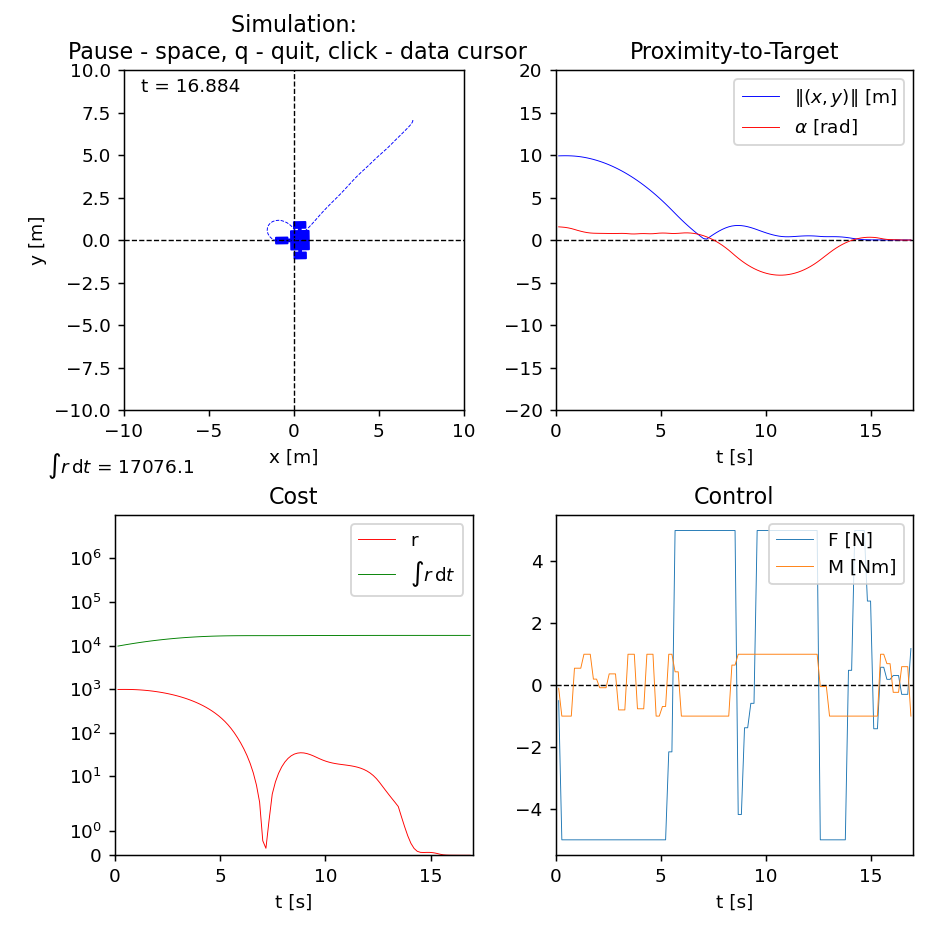

<IPython.core.display.HTML object>

In [54]:
# uncomment to run visual training option
%matplotlib notebook

# create system
sys = EndiSystem(initial_x=7, initial_y=7)

# create agent
agent = TBVILS(sys, sample_time=0.3, t1=17)

# create sim
sim = Simulation(sys, agent)

HTML(sim.run_simulation(n_runs=2, fig_width=7, fig_height=7, show_annotations=True))

In [56]:
sim.print_sim_summary_stats()

Total runs for each controller: 2
Statistics for controller 1:
            - Mean of running cost: 238.16
            - Mean of velocity: -0.85
            - SD of running cost: 354.64
            - SD of velocity: 0.82
            - SD of turning angle: 238.16
            - Final L2-norm: 0.0134
                


### Compare results from vith - on and vith - off methods


### <font color="orange">Auto-grading</font>
Run this cell to track your answers and to save your answer for problem 1.1. 

In [58]:
### GRADING DO NOT MODIFY
statistics, = sim.final_statistics

hw2_answers.record('problem_1-2', {'mean_rc': statistics[0],
    'mean_velocity': statistics[1], 
    'sd_rc': statistics[2],
    'sd_velocity': statistics[3],
    'sd_alpha': statistics[4],
    'l2_norm': statistics[5]})

### Considerations

Linear approximation is a fundamental method by which real-life RL problems are solved. This assignment showed you the basis of how they work and what their mathematical forms are. Please get comfortable with the basics of linear algebra, matrix calculus, and Python as we proceed to more diverse challenges in the coming assignments.

### <font color="orange">Auto-grading: Submit your answers</font>
Enter your first and last name in the cell below and then run it to save your answers for this lab to a JSON file. The file is saved to the same directory as this notebook. After the file is created, upload the JSON file to the assignment page on Canvas.

In [57]:
sim.print_sim_summary_stats()

Total runs for each controller: 2
Statistics for controller 1:
            - Mean of running cost: 238.16
            - Mean of velocity: -0.85
            - SD of running cost: 354.64
            - SD of velocity: 0.82
            - SD of turning angle: 238.16
            - Final L2-norm: 0.0134
                


In [59]:
hw2_answers.print_answers()

{'problem_1-2': {'mean_rc': 238.16, 'mean_velocity': -0.85, 'sd_rc': 354.64, 'sd_velocity': 0.82, 'sd_alpha': 238.16, 'l2_norm': 0.0134}}


In [60]:
!pwd

/Users/mikhailgasanov/Documents/machine_learning/stepik/RL_Skoltech/hw_2_release


In [61]:
assignment_name = "hw_2"
first_name = "Mikhail" # Use proper capitalization
last_name = "Gasanov" # Use proper capitalization

hw2_answers.save_to_json(assignment_name, first_name, last_name)

In [82]:
!ls

Gasanov_Mikhail_hw_2.json      hw_2_04_05.py
Homework_2_Update_Rcognita.pdf hw_2_06_10.ipynb
Lewis-CAS-ADP-proof.pdf        requirements.txt
__pycache__                    skoltech_logo.png
figure_11.png                  tbvils.png
hw_2.ipynb                     vi.png


### Questions?

Reach out to your instructors on Piazza.

### Sources

***

<sup>[1]</sup> Geramifard, A., Walsh, T., Tellex, S., Chowdhary, G., Roy, N., & How, J.P. (2013). A Tutorial on Linear Function Approximators for Dynamic Programming and Reinforcement Learning. Found. Trends Mach. Learn., 6, 375-451.

<sup>[2]</sup> Busoniu, L., Babuška, R., Schutter, B.D., & Ernst, D. (2010). Reinforcement Learning and Dynamic Programming Using Function Approximators.

<sup>[3]</sup> Lewis, F., & Vrabie, D. (2009). Reinforcement learning and adaptive dynamic programming for feedback control. IEEE Circuits and Systems Magazine, 9, 32-50.